In [1]:
#Import des principales librairies Python
import itertools
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
#Sarima
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
from IPython.display import clear_output
from time import time
import warnings

In [2]:
#chargement du dataset
conso=pd.read_csv('conso_elec.csv', sep=';', parse_dates=[0])
conso

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398,2021-11-01,Données consolidées,Occitanie,2142,897.0,59,NaN,0,59,638,...,60,3581,-1608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,2021-11-01,Données consolidées,Normandie,5376,4929.0,239,-1.0,31,208,5,...,58,2528,2848.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400,2021-11-01,Données consolidées,Hauts-de-France,4319,2265.0,1239,0.0,5,1233,1,...,80,4593,-273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1401,2021-11-01,Données consolidées,PACA,1745,NaN,847,-1.0,20,828,712,...,61,3561,-1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
conso.dtypes

Mois                                        datetime64[ns]
Qualité                                             object
Territoire                                          object
Production totale                                    int64
Production nucléaire                               float64
Production thermique totale                          int64
Production thermique charbon                       float64
Production thermique fioul                           int64
Production thermique gaz                             int64
Production hydraulique                               int64
Production éolien                                    int64
Production solaire                                   int64
Production bioénergies                               int64
Consommation totale                                  int64
Solde exportateur                                  float64
Echanges export                                    float64
Echanges import                                    float

In [4]:
#Valeur manquantes
conso.isnull().sum()

Mois                                           0
Qualité                                        0
Territoire                                     0
Production totale                              0
Production nucléaire                         490
Production thermique totale                    0
Production thermique charbon                 429
Production thermique fioul                     0
Production thermique gaz                       0
Production hydraulique                         0
Production éolien                              0
Production solaire                             0
Production bioénergies                         0
Consommation totale                            0
Solde exportateur                             87
Echanges export                             1284
Echanges import                             1284
Echanges avec le Royaume-Uni                1284
Echanges avec l'Espagne                     1284
Echanges avec l'Italie                      1284
Echanges avec la Sui

In [5]:
#Méthode .duplicated() pour identifier la présence de doublons
print(conso.duplicated().sum())

0


In [6]:
conso1=conso.copy()
conso1=conso1[['Mois','Territoire','Consommation totale']]
conso1=conso1[conso['Territoire']=='France']
conso1.head()

,Mois,Territoire,Consommation totale
0,2012-01-01,France,51086
1,2012-02-01,France,54476
2,2012-03-01,France,43156
3,2012-04-01,France,40176
4,2012-05-01,France,35257


In [7]:
conso1.sort_values(by='Mois',ascending=True).head()

,Mois,Territoire,Consommation totale
0,2012-01-01,France,51086
1,2012-02-01,France,54476
2,2012-03-01,France,43156
3,2012-04-01,France,40176
4,2012-05-01,France,35257


In [8]:
del conso1['Territoire']

In [9]:
conso1.rename(columns={'Consommation totale': 'consommation'}, inplace=True)
#Sinon la serie temporelle ne sera pas reconnu 
conso1.set_index('Mois', inplace=True)


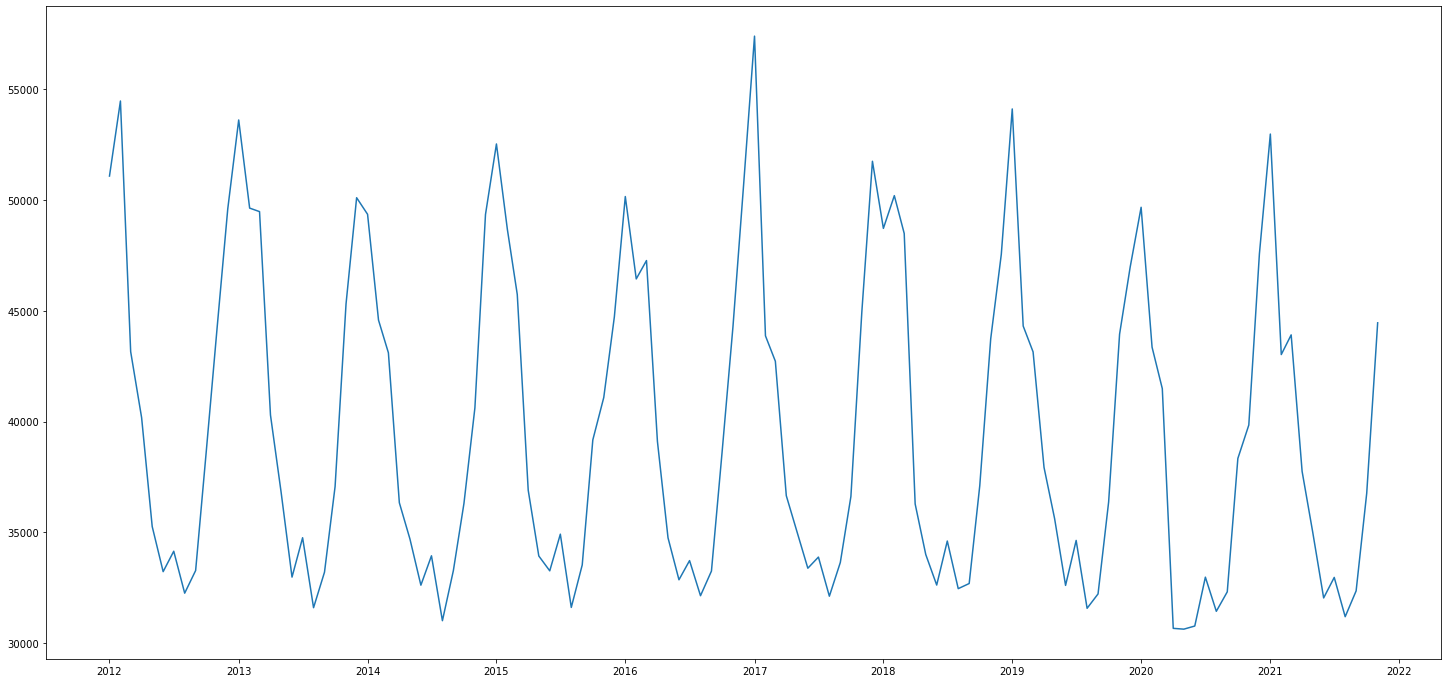

In [10]:
#Visualisation de conso1
fig = plt.figure(figsize=(25,12))
plt.plot(conso1.consommation)
plt.show()

In [11]:
#On constate une saisonnalité  sur la consommation totale avec un léger pic pour 2017

In [12]:
conso2=conso.copy()
conso2=conso2[['Mois','Territoire','Consommation totale']]
conso2=conso2[conso['Territoire']!='France']
conso2

,Mois,Territoire,Consommation totale
12,2013-01-01,Grand-Est,0
13,2013-01-01,Nouvelle-Aquitaine,0
14,2013-01-01,Auvergne-Rhône-Alpes,0
15,2013-01-01,Bourgogne-Franche-Comté,0
16,2013-01-01,Bretagne,0
...,...,...,...
1398,2021-11-01,Occitanie,3581
1399,2021-11-01,Normandie,2528
1400,2021-11-01,Hauts-de-France,4593
1401,2021-11-01,PACA,3561


In [13]:
conso2.sort_values(by='Mois',ascending=True).head()

,Mois,Territoire,Consommation totale
12,2013-01-01,Grand-Est,0
24,2013-01-01,Pays-de-la-Loire,0
23,2013-01-01,PACA,0
22,2013-01-01,Hauts-de-France,0
20,2013-01-01,Occitanie,0


In [14]:
conso2[conso2['Consommation totale']!=0]

,Mois,Territoire,Consommation totale
168,2014-01-01,Grand-Est,4594
169,2014-01-01,Nouvelle-Aquitaine,4501
170,2014-01-01,Auvergne-Rhône-Alpes,6693
171,2014-01-01,Bourgogne-Franche-Comté,2158
172,2014-01-01,Bretagne,2390
...,...,...,...
1398,2021-11-01,Occitanie,3581
1399,2021-11-01,Normandie,2528
1400,2021-11-01,Hauts-de-France,4593
1401,2021-11-01,PACA,3561


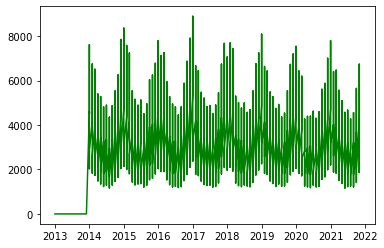

In [15]:
conso2.set_index('Mois',inplace=True)
plt.plot(conso2['Consommation totale'],color='Green')

plt.show()

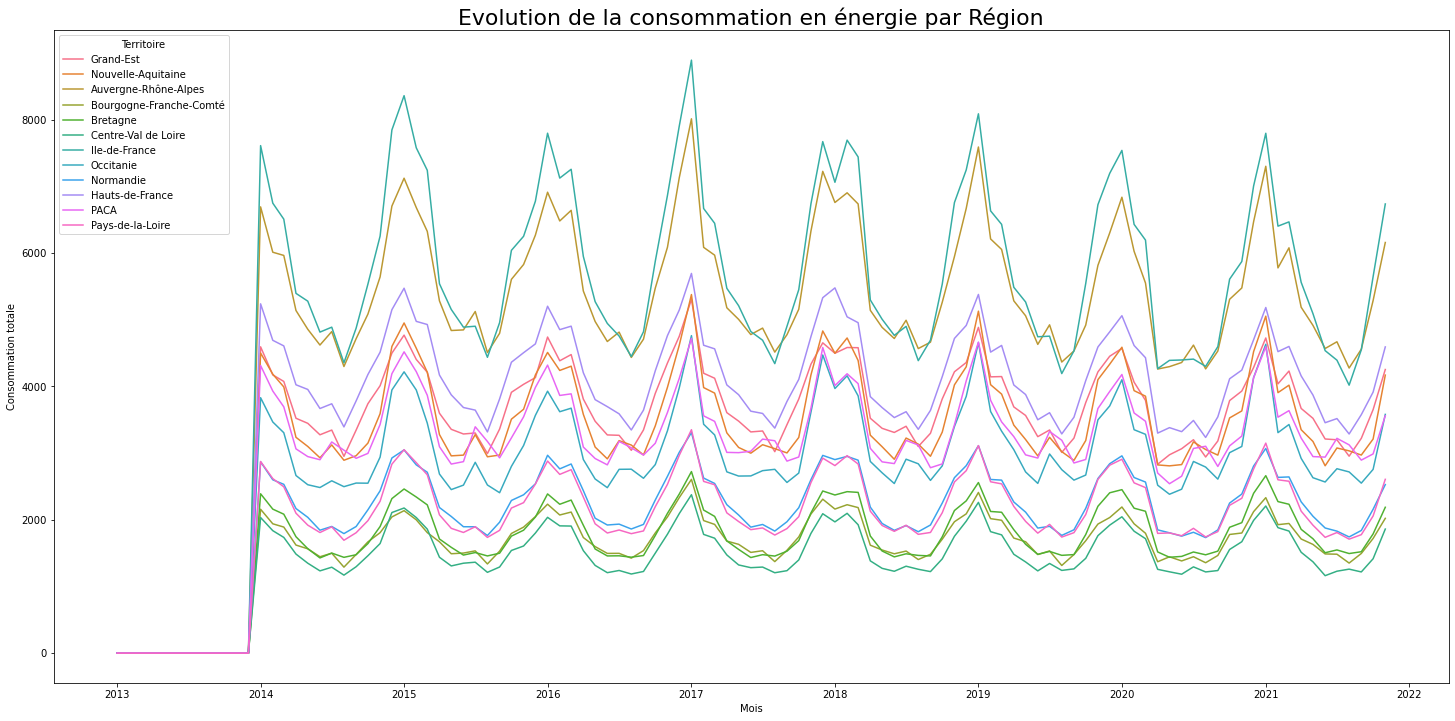

In [16]:
fig = plt.figure(figsize=(25,12))
sns.lineplot(data=conso2, x=conso2.index,  y="Consommation totale", hue="Territoire")
plt.title("Evolution de la consommation en énergie par Région", fontsize=22)
plt.show()


In [17]:
allfiles=['djuH1a.xlsx','djuH1c.xlsx','djuH2a.xlsx','djuH2b.xlsx','djuH2c.xlsx','djuH2d.xlsx','djuH3.xlsx']

dataframes=[]

for filenames in allfiles:
    df=pd.read_excel('%s' % (filenames),header=None, skiprows=11)
    dataframes.append(df)
    
result=pd.concat(dataframes)

print(result.head())

       0      1      2      3      4      5     6     7     8     9      10  \
0     NaN    JAN    FÉV    MAR    AVR    MAI   JUN   JUI   AOÛ   SEP    OCT   
1  2021.0  460.2  358.5  333.6  317.5  199.6  13.1     0     0     0      0   
2  2020.0  387.4  310.9  333.4  159.6    132  50.6  23.9    18  57.7  194.7   
3  2019.0  460.1  322.4  294.4    232  191.3  49.2    21  22.4    79  176.6   
4  2018.0  362.1  473.4  381.4  168.2   97.3  40.1   1.4  21.7  83.2  183.3   

      11     12      13  
0    NOV    DÉC   Total  
1      0      0  1682.4  
2  279.4  388.2  2335.6  
3  335.6  385.9  2569.5  
4  322.7  379.1  2513.4  


In [18]:
result.drop([0, 1], axis=0, inplace=True)
result.drop([13], axis=1,inplace=True)
result.dropna(how='any')

,0,1,2,3,4,5,6,7,8,9,10,11,12
2,2020.0,387.4,310.9,333.4,159.6,132,50.6,23.9,18,57.7,194.7,279.4,388.2
3,2019.0,460.1,322.4,294.4,232,191.3,49.2,21,22.4,79,176.6,335.6,385.9
4,2018.0,362.1,473.4,381.4,168.2,97.3,40.1,1.4,21.7,83.2,183.3,322.7,379.1
5,2017.0,529.4,331.5,269.3,273.3,110.8,24.6,14.7,24.5,112.7,157.8,339,414.8
6,2016.0,415.1,363.3,373.8,278.8,133.4,61,23.5,21.4,37.9,233.1,345.1,452.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2013.0,311.1,310.1,236.4,117.9,60.9,9.6,0,0,0,22,177.6,247.9
10,2012.0,282.9,335.2,182.7,113.2,56.6,0,0,0,0.1,48.1,146.1,275.1
11,2011.0,297.5,260.9,218.5,104.1,19.5,1.8,0,0,0,63.6,125.2,238.4
12,2010.0,349.4,284.5,228.4,128.5,60.2,1.1,0,0,12.1,80,203.9,328.3


In [19]:
result.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [20]:
result.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12
2,2020.0,387.4,310.9,333.4,159.6,132,50.6,23.9,18,57.7,194.7,279.4,388.2
3,2019.0,460.1,322.4,294.4,232,191.3,49.2,21,22.4,79,176.6,335.6,385.9
4,2018.0,362.1,473.4,381.4,168.2,97.3,40.1,1.4,21.7,83.2,183.3,322.7,379.1
5,2017.0,529.4,331.5,269.3,273.3,110.8,24.6,14.7,24.5,112.7,157.8,339,414.8
6,2016.0,415.1,363.3,373.8,278.8,133.4,61,23.5,21.4,37.9,233.1,345.1,452.3
7,2015.0,444.3,410.9,340.9,220.4,167.1,69.1,27.8,16.9,129.7,229.2,249.8,284.5
8,2014.0,372.9,322.9,297.5,191.7,150.2,56.4,20.1,55.3,51.1,131.9,274.9,421.9
9,2013.0,498.1,454.1,450.1,272.2,218.1,83.7,15.9,21.1,91.8,155.7,346,396.1
10,2012.0,398.1,497.8,274.3,291.4,137.7,82.6,43.3,13.9,109.1,202.8,338,394.4
11,2011.0,436.4,356.2,313.1,139.1,121.6,66.7,58.5,37.2,61.4,182.9,294,361.2


In [21]:
result[0] = result[0].astype(int)
result.set_index([0], inplace=True)

In [22]:
re=result.groupby([0]).sum()

In [23]:
re

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2009,3162.6,2477.8,2064.3,1233.2,490.2,191.3,54.9,33.4,223.1,983.0,1520.4,2730.0
2010,3370.4,2585.3,2173.1,1273.4,978.7,215.6,16.6,111.2,417.8,1167.4,2067.6,3258.0
2011,2795.8,2140.7,1884.6,793.7,406.4,274.3,170.0,98.2,170.3,893.2,1490.6,2260.3
2012,2562.7,3216.6,1638.8,1538.3,651.5,208.9,127.4,36.5,365.1,904.2,1846.8,2471.9
2013,2858.9,2759.5,2282.9,1464.0,1151.1,319.7,19.9,44.3,260.9,637.8,2074.0,2515.2
2014,2291.3,2012.0,1805.6,1062.6,778.1,145.7,66.6,141.5,159.1,552.0,1433.0,2516.5
2015,2687.1,2549.1,1922.2,1123.4,611.9,134.6,55.4,51.7,463.5,1151.6,1483.4,1893.0
2016,2380.3,2141.6,2153.5,1389.3,698.9,209.1,69.3,40.5,130.6,1136.9,1874.3,2633.6
2017,3211.0,1889.2,1544.3,1373.1,567.9,96.1,37.7,75.2,463.1,701.5,2059.2,2685.6


In [24]:
#Transformation des données
dju2 = {'Mois':[],'dju_chauffage':[]}

for year in re.index.values:
    for month in re.columns:
        dju2['Mois'].append(f"{year}-{month}")
        dju2['dju_chauffage'].append(re.loc[year,month])
        
dju2 = pd.DataFrame(dju2)
dju2['Mois'] = pd.to_datetime(dju2['Mois'])

In [25]:
#Indexation des données selon les mois d'enregistrement
dju2.set_index('Mois', inplace=True)

In [26]:
dju2.head()

,dju_chauffage
Mois,
2009-01-01,3162.6
2009-02-01,2477.8
2009-03-01,2064.3
2009-04-01,1233.2
2009-05-01,490.2


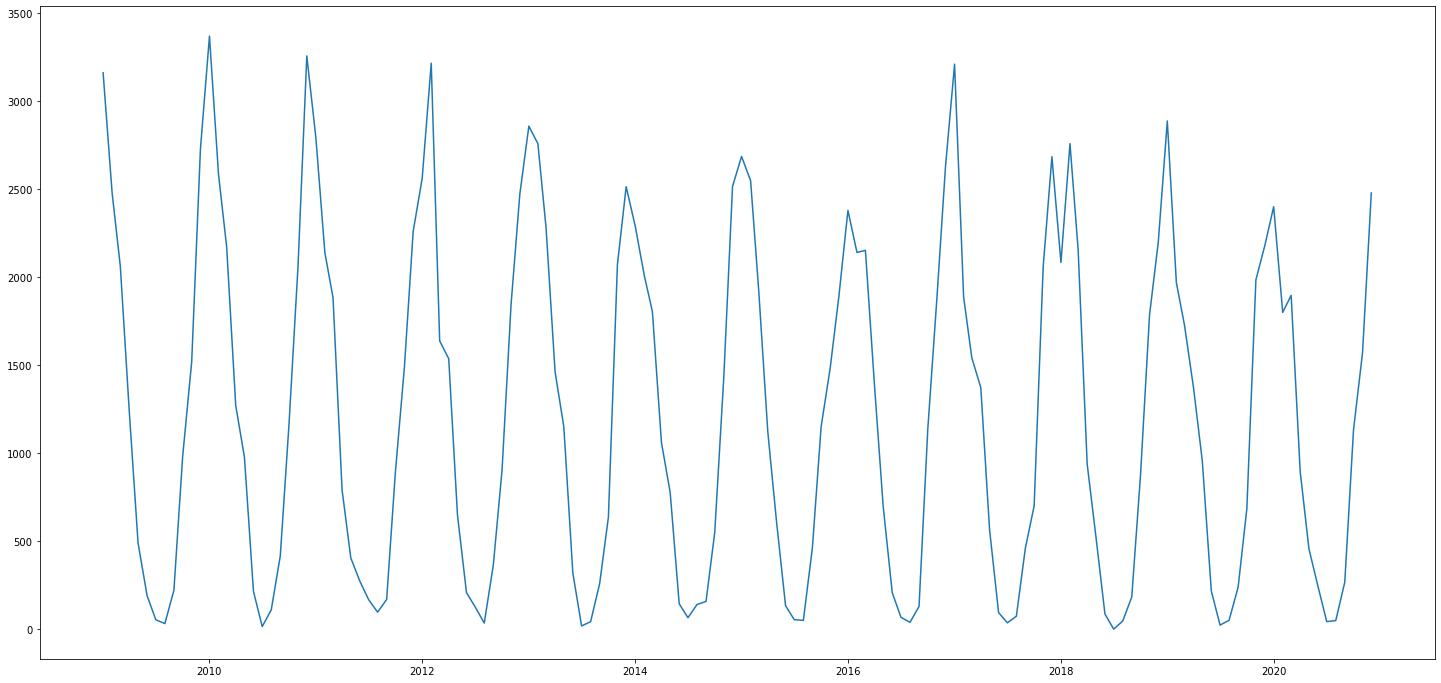

In [27]:
#Visualisation de dju
fig = plt.figure(figsize=(25,12))
plt.plot(dju2.dju_chauffage)
plt.show()

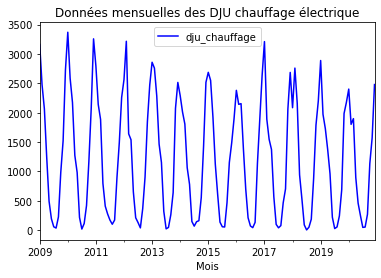

In [28]:
#Visualisation des données mensuelles des Degrés Jour Unifiés (DJU) chauffage électrique

dju2.plot(color='b')
plt.title("Données mensuelles des DJU chauffage électrique")
plt.show()

In [29]:
#Création d'un échantillon de travail par jointure des deux précédents dataframe
df1= pd.merge(conso1, dju2, how='inner', on='Mois')

In [30]:
df1

,consommation,dju_chauffage
Mois,,
2012-01-01,51086,2562.7
2012-02-01,54476,3216.6
2012-03-01,43156,1638.8
2012-04-01,40176,1538.3
2012-05-01,35257,651.5
...,...,...
2020-08-01,31428,50.3
2020-09-01,32307,268.3
2020-10-01,38332,1133.4


In [31]:
#Vérification rapide des éventuelles valeurs manquantes dans l'échantillon
df1.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

In [32]:
df1.describe()

,consommation,dju_chauffage
count,108.000000,108.000000
mean,39737.250000,1202.010185
std,7086.595702,963.585624
min,30622.000000,1.800000
25%,33347.750000,216.000000
50%,37082.500000,1128.400000
75%,45047.500000,2023.800000
max,57406.000000,3216.600000


# Correction des données mensuelles des temperatures 

In [33]:
#Préparation des données pour établir la Régression linéaire 
y=df1['consommation']
x=df1.drop(columns=['consommation'])

In [34]:
#Régression linéaire par Scikit-learn
#Instanciation et entrainement du modèle
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)

LinearRegression()

In [35]:
#Coefficient de régression linéaire
reg.coef_[0]

7.1351541505954375

In [36]:
#Préparation des données pour établir la Régression linéaire
y = df1['consommation']
x = sm.add_constant(df1['dju_chauffage'])

In [37]:
#Nouvelle Régression linéaire par Statsmodels
#Instanciation du modèle et entrainement
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1699.
Date:                Fri, 18 Feb 2022   Prob (F-statistic):           4.49e-67
Time:                        17:37:38   Log-Likelihood:                -957.19
No. Observations:                 108   AIC:                             1918.
Df Residuals:                     106   BIC:                             1924.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.116e+04    266.215    117.051

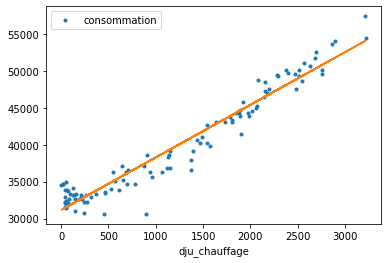

In [38]:
#Représentation de la Régression linéaire obtenue
df1.plot(x='dju_chauffage', y='consommation', style='.')
plt.plot(df1['dju_chauffage'], reg.predict(sm.add_constant(df1['dju_chauffage'])))

plt.show()


In [39]:
#Coefficient de régression linéaire
reg.params['dju_chauffage']

7.135154150595435

In [40]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
df1['conso_corr'] = df1['consommation'] - df1['dju_chauffage']*reg.params['dju_chauffage']

In [41]:
#retirer de la consommation la part du dju (pondération du dju) 

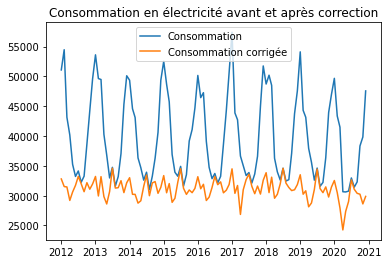

In [42]:
#Visualisation de la consommation en électricité avant et après correction
plt.plot(df1['consommation'], label='Consommation')
plt.plot(df1['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.legend()
plt.show()

# Test des résidus

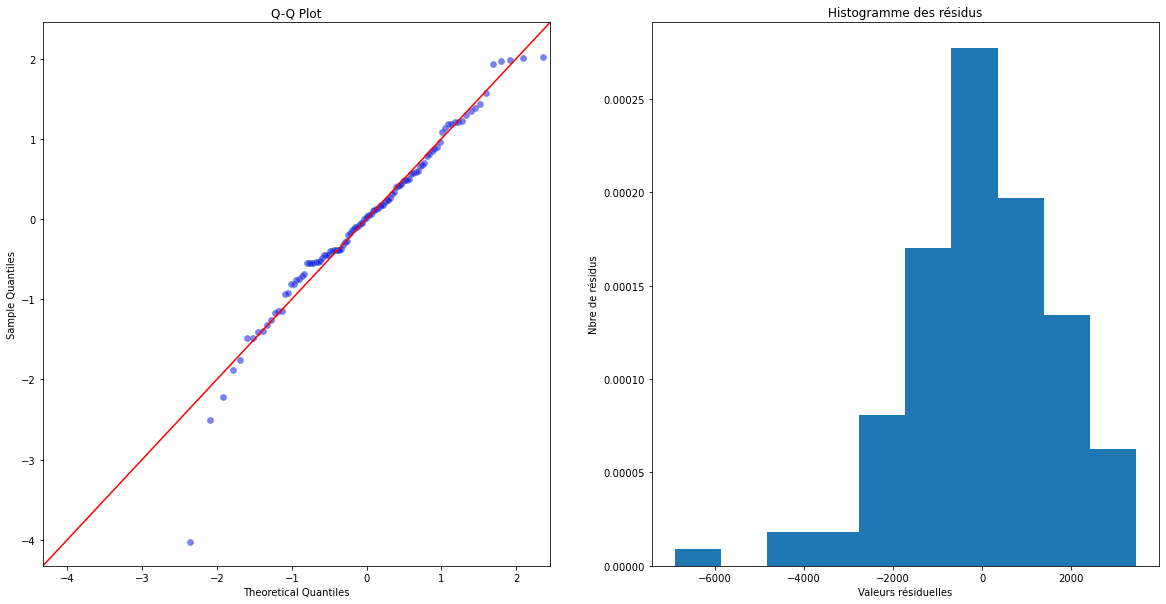

In [43]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(reg.resid, density=True)

model_norm_residuals = reg.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nbre de résidus')
                

plt.show()

In [44]:
#Test de Shapiro-Wilk
shapiro(reg.resid)

ShapiroResult(statistic=0.970834493637085, pvalue=0.01781165972352028)

# Désaisonnalisation de la consommation obtenue après correction grâce aux moyennes mobiles


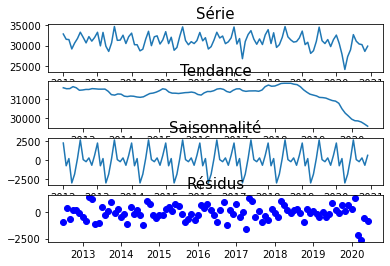

In [45]:
#La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signa
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df1['conso_corr'],  model='additive')
fig, ax = plt.subplots(4,1)
ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=15)
ax[1].plot(decomposition.trend)
ax[1].set_title('Tendance', fontsize=15)
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Saisonnalité', fontsize=15)
ax[3].plot(decomposition.resid,'bo')
ax[3].set_title('Résidus', fontsize=15)


plt.show()


In [46]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier.
df1['conso_cvs'] = df1['conso_corr'] - decomposition.seasonal

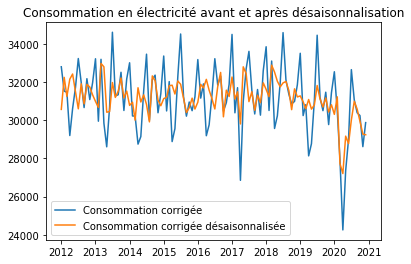

In [47]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.plot(df1['conso_corr'], label='Consommation corrigée')
plt.plot(df1['conso_cvs'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')


plt.legend()
plt.show()

In [48]:
#Le signal ressort corrigé et désaisonnalisé, il est de plus en plus représentatif d'un modèle additif.

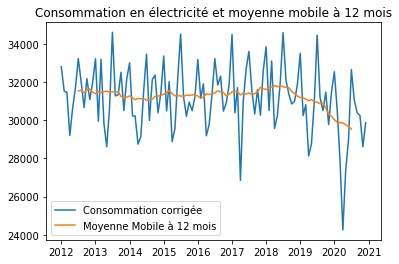

In [49]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(df1['conso_corr'], label='Consommation corrigée')
plt.plot(df1['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.legend()
plt.show()

In [50]:
#Le moyenne mobile à 12 mois affichée ci-dessus est représentative d'un signal sans tendance, constant sur le timeframe.

# Prévision de la consommation (corrigée de l'effet température) sur un an

C:\Users\33753\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


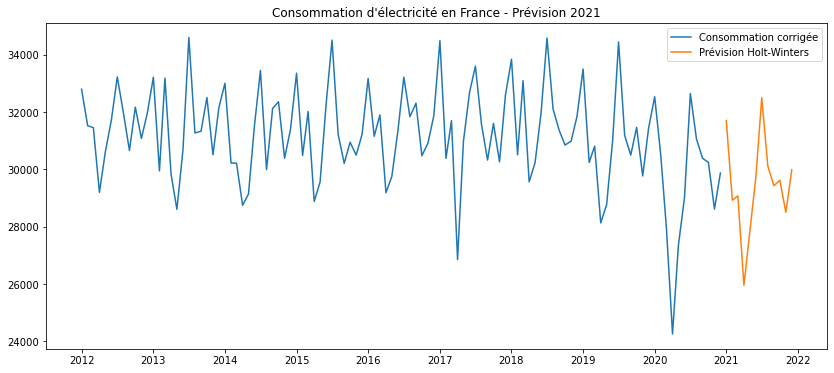

In [51]:
from statsmodels.tsa.api import ExponentialSmoothing
import numpy as np
hw = ExponentialSmoothing(np.asarray(df1['conso_corr']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df1['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')
plt.title("Consommation d'électricité en France - Prévision 2021")

plt.legend()
plt.show()

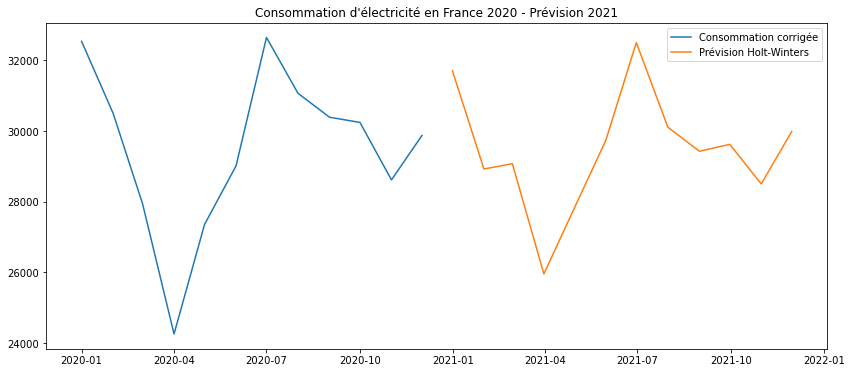

In [52]:
#Visualisation par restriction sur l'année de prévision et n-1 (2020/2021)
plt.figure(figsize=(14,6))
plt.plot(df1["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(pd.date_range(df1.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')


plt.title("Consommation d'électricité en France 2020 - Prévision 2021")
        
plt.legend()

plt.show()

In [53]:
#Troncature des données sur les années 2019 et 2020
df_tronc = df1[:'2019']
x_prevision = df1['2020':]

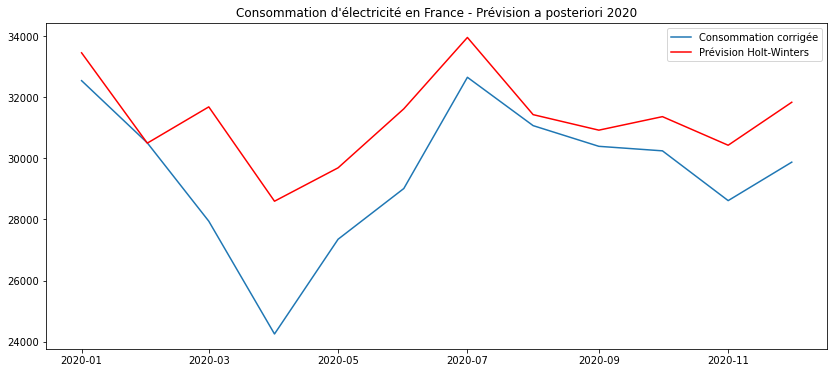

In [54]:
#Visualisation par restriction sur l'année 2020
plt.figure(figsize=(14,6))
warnings.filterwarnings('ignore')
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.plot(df1["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2020")


plt.legend()
plt.show()

In [55]:
#on peut pas predire certains outliers

In [56]:
#Par les chiffres nous pouvons calculer le MAPE (Mean Absolute Percentage). 
#L’erreur absolue moyenne en pourcentage, en d'autres termes la moyenne des écarts en valeur absolue par rapport aux valeurs observées.
#Precision  de la prediction

In [57]:
#Calcule du mape le MAPE (Mean Absolute Percentage). 
#L’erreur absolue moyenne en pourcentage, en d'autres termes la moyenne des écarts en valeur absolue par rapport aux valeurs observées.
mape=(np.abs(1-hw_pred/x_prevision['conso_corr'])).mean()*100
mape

6.258184215671586

# ANALYSE POSTERIORI SUR 24 MOIS

In [58]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df1[:'2018']
x_prevision = df1['2019':]

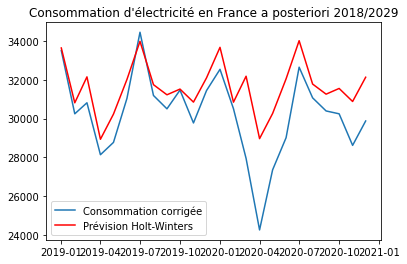

In [59]:
#Visualisation par restriction sur les années de prévision 2018 et 2019
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(24)

plt.plot(df1["conso_corr"].iloc[-24:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France a posteriori 2018/2029")


plt.legend()
plt.show()

In [60]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
print("MAPE :" + str(mape))

MAPE :4.94


In [61]:
#Le modele posteriori sur 24 mois resiste plus au impacts saisonnier sur le long terme 

In [62]:
#Fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [63]:
y=df1['conso_corr']

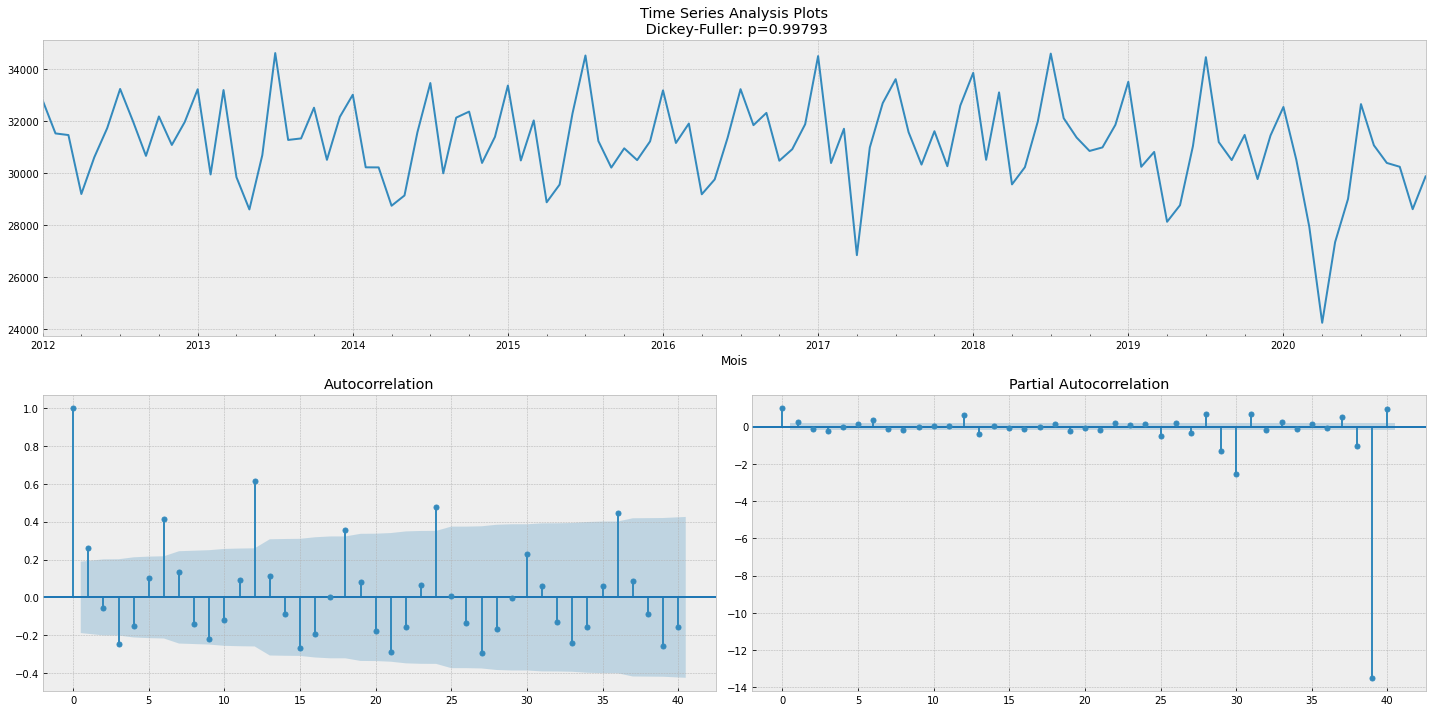

In [64]:
#Test de Dickey–Fuller avec Autocorrélogrammes ACF et PACF
warnings.filterwarnings('ignore')
tsplot(y, lags=40)


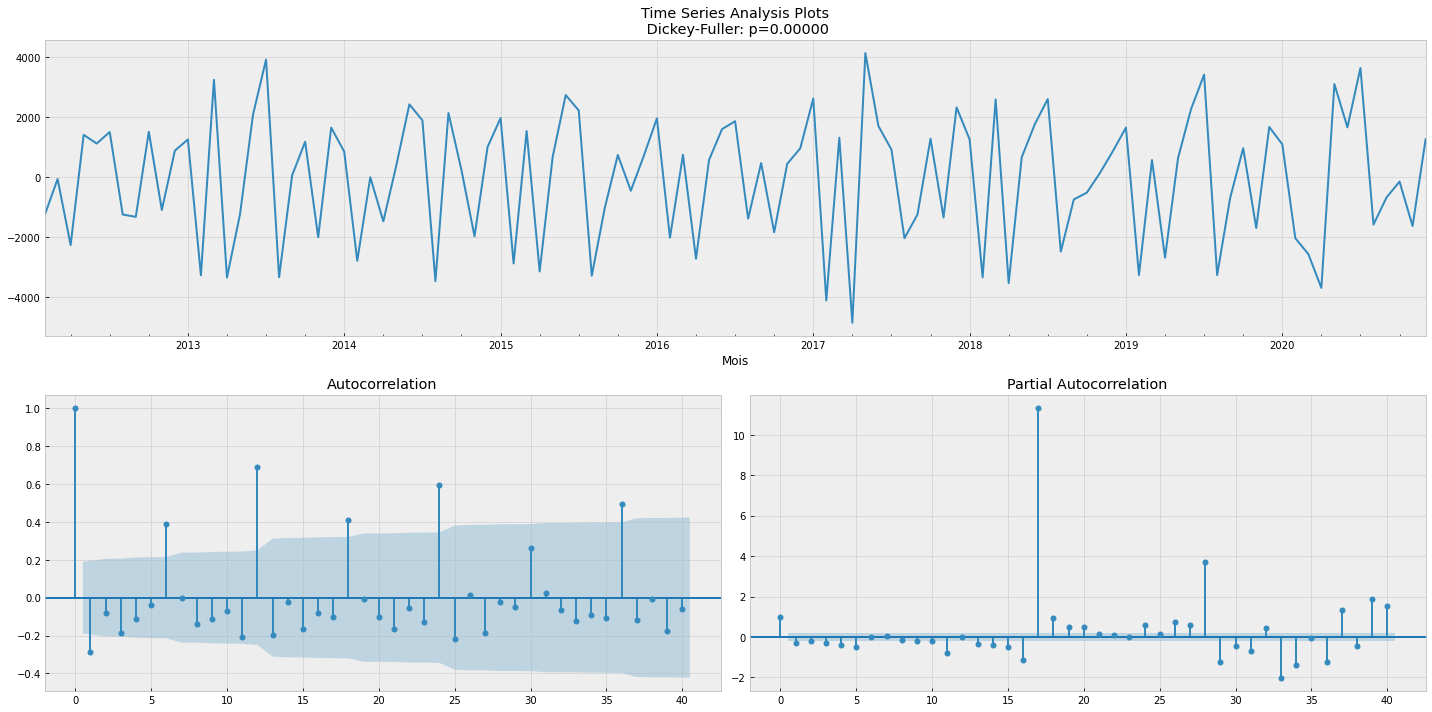

In [65]:
#Première différenciation d'ordre 1 par la méthode .shift()
warnings.filterwarnings('ignore')
df_diff = y- y.shift(1)
tsplot(df_diff[1:], lags=40)

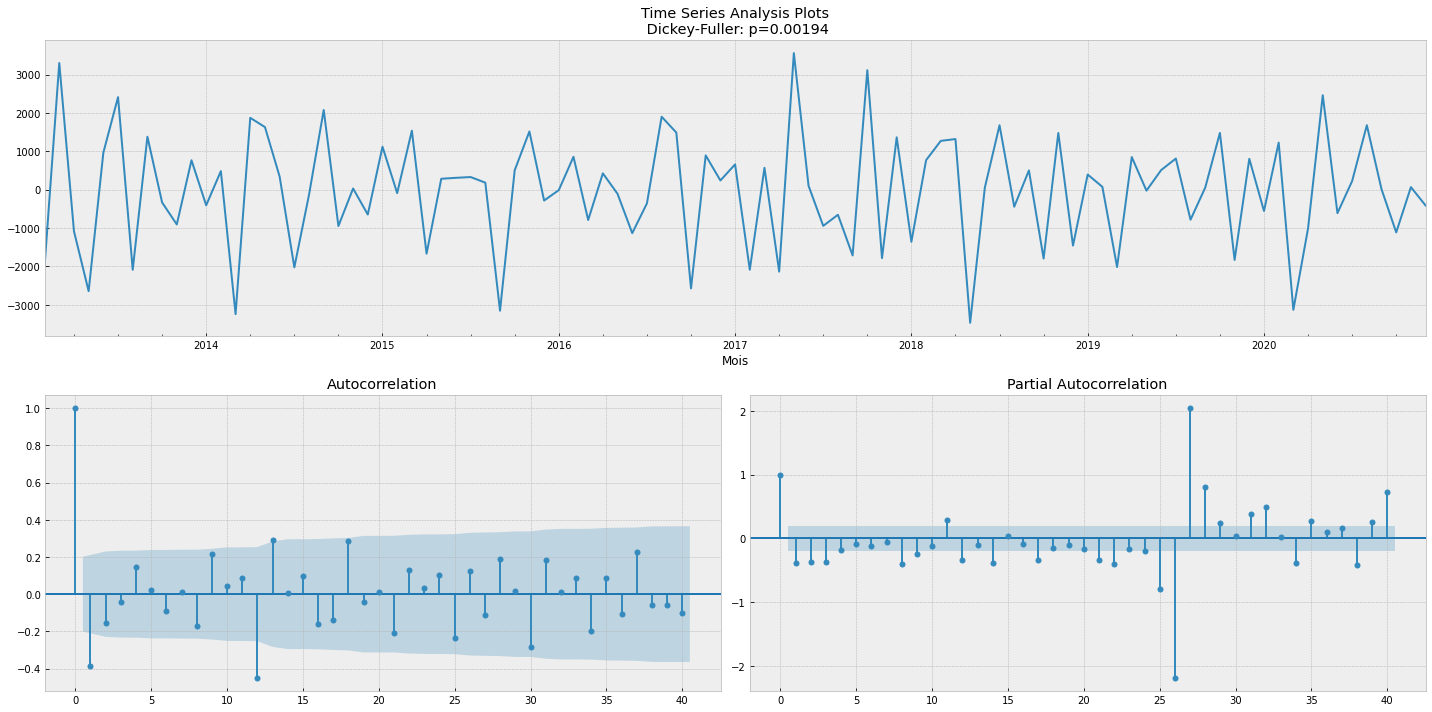

In [66]:
#Seconde différenciation d'ordre 12 
warnings.filterwarnings('ignore')
df_diff12 = df_diff - df_diff.shift(12)
tsplot(df_diff12[13:], lags=40)

In [67]:
#Détermination du meilleur modèle de prévision 
from time import time
DUREE_PREDITE = 12 #prédiction sur 12 mois
troncature = DUREE_PREDITE

y_prevision = y[-troncature:]

#Calcul de toutes les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=12)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

324/324 - 111s


In [68]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [69]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [70]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
239,"(2, 0, 1)x(0, 1, 2, 12)",12.000000,25.490971,0.825233,0.000000,1.000000,1.000000
245,"(2, 0, 1)x(1, 1, 2, 12)",14.000000,29.739467,0.825212,0.000000,2.000000,2.000000
215,"(1, 1, 2)x(2, 1, 2, 12)",16.000000,33.756062,0.824176,0.000000,4.000000,3.000000
251,"(2, 0, 1)x(2, 1, 2, 12)",16.000000,33.987962,0.825212,0.000000,4.000000,5.000000
305,"(2, 1, 1)x(2, 1, 2, 12)",16.000000,33.872852,0.706905,0.000000,4.000000,4.000000
197,"(1, 1, 1)x(2, 1, 2, 12)",376.104717,391.743463,0.307812,0.000000,6.000000,6.000000
304,"(2, 1, 1)x(2, 1, 1, 12)",1158.793596,1174.432342,0.853557,0.000000,7.000000,7.000000
322,"(2, 1, 2)x(2, 1, 1, 12)",1160.781703,1178.654555,0.920118,0.000000,8.000000,11.000000
303,"(2, 1, 1)x(2, 1, 0, 12)",1162.403700,1175.808339,0.907873,0.000000,9.000000,8.000000
321,"(2, 1, 2)x(2, 1, 0, 12)",1163.437411,1179.076156,0.277874,0.000000,10.000000,12.000000


In [71]:
model = SARIMAX(np.asarray(y), order=(0, 1 ,0), seasonal_order = (2,1,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -822.723
Date:                            Fri, 18 Feb 2022   AIC                           1651.445
Time:                                    17:39:33   BIC                           1659.107
Sample:                                         0   HQIC                          1654.541
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2432      0.052     -4.658      0.000      -0.345      -0.141
ar.S.L24      -0.1355      0.060   

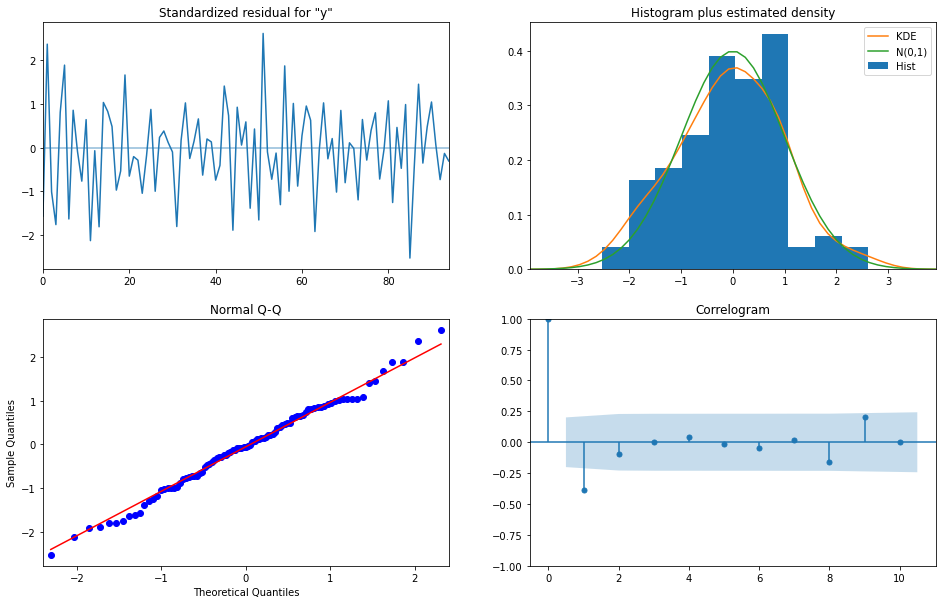

In [72]:
#Vérifier la normalité des résidus pour tester l'adéquation de nos modèles
results.plot_diagnostics(figsize=(16,10));


In [73]:
#La représentation "Standardized residual" et "Correlogram" confirment qu'il n'y a pas de corrélation des résidus.
#Les résidus sont normalement distribués KDE vs distribution normale - N (0,1). La distribution ordonnée des résidus représentée par le du Q-Q plot est globalement satisfaisant,


In [74]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.4403987526893616, pvalue=1.9381573806959548e-18)

In [75]:
#La distribution de nos résidus semble suivre une loi normale. On vérifie cela avec un test de Shapiro-Wilk se basant sur les hypothèses suivantes :

#H0 : Il est peu probable que la distribution de nos résidus suive une loi normale
#H1 : Il est probable que la distribution de nos résidus suive une loi normale
#La p-value est inférieure à 0.05. On peut donc rejeter l'hypothèse H0 selon laquelle il est peu probable que la distribution de nos résidus suive un loi normale.

In [76]:
#Test de Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.9573815754970738

In [77]:
#Le test de Jarque-Bera ne teste pas à proprement parler si les données suivent une loi normale, 
#mais plutôt si le kurtosis et le coefficient d'asymétrie des données sont les mêmes que ceux d'une loi normale de même espérance et variance.

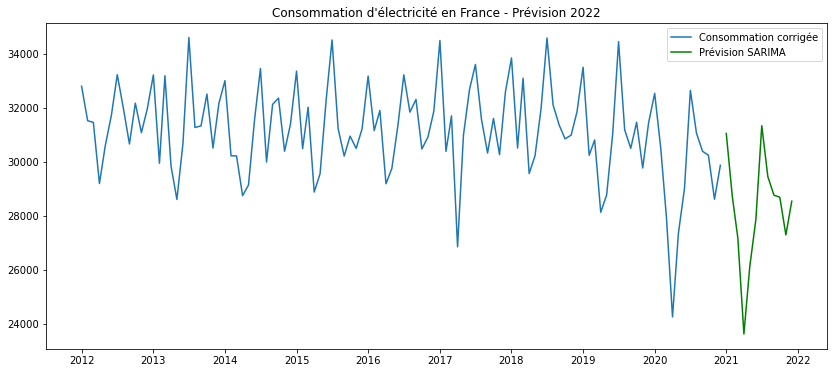

In [78]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
plt.figure(figsize=(14,6))
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(df1['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(df1.index[len(df1)-1], periods=12, freq='M'), pred, color='g', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2022")
plt.legend()


plt.show() 

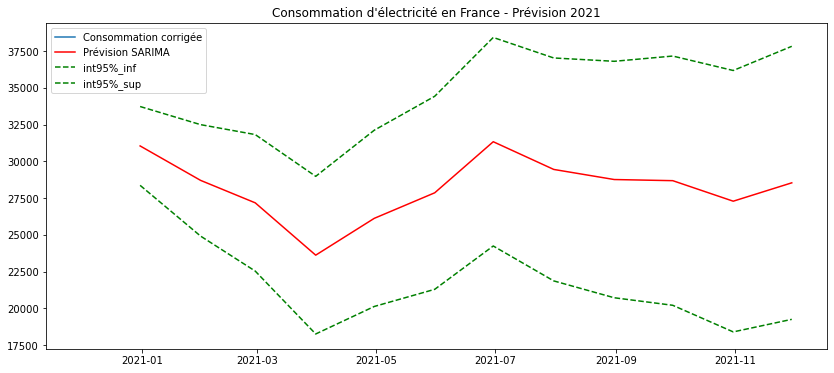

In [86]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
plt.figure(figsize=(14,6))

pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(df1['conso_corr'].iloc[-1:], label='Consommation corrigée')
plt.plot(pd.date_range(df1.index[len(df1)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df1.index[len(df1)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(df1.index[len(df1)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2021")
plt.legend()

plt.show() 

# Analyse a posteriori

In [80]:
#Troncature des données sur les années 2019 et 2020
df_tronc = df1[:'2019'] 
x_prevision = df1['2020':]  
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(0,1,0), seasonal_order=(2,1,0,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -719.040
Date:                            Fri, 18 Feb 2022   AIC                           1444.080
Time:                                    17:39:35   BIC                           1451.336
Sample:                                         0   HQIC                          1446.995
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2433      0.057     -4.234      0.000      -0.356      -0.131
ar.S.L24      -0.1241      0.070   

In [81]:
#Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%

In [82]:
x_prevision

,consommation,dju_chauffage,conso_corr,conso_cvs
Mois,,,,
2020-01-01,49676,2401.6,32540.213792,30307.448037
2020-02-01,43358,1801.2,30506.160344,31226.683883
2020-03-01,41486,1897.9,27944.190938,27729.754380
2020-04-01,30658,897.3,24255.626181,27207.904656
2020-05-01,30622,458.0,27354.099399,29167.059897
2020-06-01,30763,245.3,29012.746687,28772.367130
2020-07-01,32970,44.8,32650.345094,30016.835477
2020-08-01,31428,50.3,31069.101746,30989.398235
2020-09-01,32307,268.3,30392.638141,30583.554734


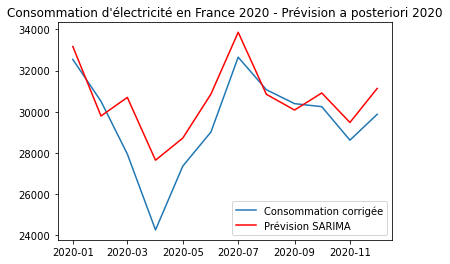

In [83]:
#Visualisation par restriction sur l'année 2020
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df1["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2020 - Prévision a posteriori 2020")
        
plt.legend()
plt.show()




In [84]:
mape = round((np.abs(1-pred_tronc/x_prevision["conso_corr"])).mean()*100, 2)
mape

4.52

# Prévision à 12 mois performante, la méthode SARIMA semble mieux prendre en compte les impacts saisonniers (pics et creux).

In [85]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df1[:'2018']
x_prevision = df1['2019':]
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -616.867
Date:                            Fri, 18 Feb 2022   AIC                           1245.735
Time:                                    17:39:35   BIC                           1259.311
Sample:                                         0   HQIC                          1251.134
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4305      0.282      1.527      0.127      -0.122       0.983
ma.L1         -0.5433      0.274   